In [439]:
# Utility libraries
import  os
from    dotenv                 import load_dotenv
from    pathlib                import Path
import  calendar
from    datetime               import *
import  requests
from    dateutil.relativedelta import *

# APIs
from    fredapi                import Fred
import  yfinance               as     yf

# Modeling libraries
import  numpy                  as     np
import  pandas                 as     pd
from    fbprophet              import Prophet
from    MCForecastTools        import MCSimulation

# Visualisation libraries
import  seaborn                as     sns
import  holoviews              as     hv
import  hvplot.pandas
import  plotly.express         as     px
import  matplotlib.pyplot      as     plt

# Set ups
plt.style.use("fivethirtyeight")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
pd.set_option("max_columns", 500)

### Retrieving historical data for the chosen crypto currencies from Yahoo Finance

In [360]:
data_df = yf.download(
    "BTC-USD, ETH-USD, BNB-USD, DOGE-USD, XMR-USD, XEM-USD", 
    period="max"
)

[*********************100%***********************]  6 of 6 completed


In [361]:
# Review data to see the date ranges
display(data_df.head())
display(data_df.tail())

Adj Close                                                Close  \
             BNB-USD     BTC-USD DOGE-USD ETH-USD XEM-USD XMR-USD BNB-USD   
Date                                                                        
2014-09-17       NaN  457.334015      NaN     NaN     NaN     NaN     NaN   
2014-09-18       NaN  424.440002      NaN     NaN     NaN     NaN     NaN   
2014-09-19       NaN  394.795990      NaN     NaN     NaN     NaN     NaN   
2014-09-20       NaN  408.903992      NaN     NaN     NaN     NaN     NaN   
2014-09-21       NaN  398.821014      NaN     NaN     NaN     NaN     NaN   

                                                           High              \
               BTC-USD DOGE-USD ETH-USD XEM-USD XMR-USD BNB-USD     BTC-USD   
Date                                                                          
2014-09-17  457.334015      NaN     NaN     NaN     NaN     NaN  468.174011   
2014-09-18  424.440002      NaN     NaN     NaN     NaN     NaN  456.859985   
2014-09-19  394.795990      NaN     NaN     NaN     NaN     NaN  427.834991   
2014-09-20  408.903992      NaN     NaN     NaN     NaN     NaN  423.295990   
2014-09-21  398.821014      NaN     NaN     NaN     NaN     NaN  412.425995   

                                                Low                       \
           DOGE-USD ETH-USD XEM-USD XMR-USD BNB-USD     BTC-USD DOGE-USD   
Date                                                                       
2014-09-17      NaN     NaN     NaN     NaN     NaN  452.421997      NaN   
2014-09-18      NaN     NaN     NaN     NaN     NaN  413.104004      NaN   
2014-09-19      NaN     NaN     NaN     NaN     NaN  384.532013      NaN   
2014-09-20      NaN     NaN     NaN     NaN     NaN  389.882996      NaN   
2014-09-21      NaN     NaN     NaN     NaN     NaN  393.181000      NaN   

                                      Open                               \
           ETH-USD XEM-USD XMR-USD BNB-USD     BTC-USD DOGE-USD ETH-USD   
Date                                                                      
2014-09-17     NaN     NaN     NaN     NaN  465.864014      NaN     NaN   
2014-09-18     NaN     NaN     NaN     NaN  456.859985      NaN     NaN   
2014-09-19     NaN     NaN     NaN     NaN  424.102997      NaN     NaN   
2014-09-20     NaN     NaN     NaN     NaN  394.673004      NaN     NaN   
2014-09-21     NaN     NaN     NaN     NaN  408.084991      NaN     NaN   

                            Volume                                             
           XEM-USD XMR-USD BNB-USD   BTC-USD DOGE-USD ETH-USD XEM-USD XMR-USD  
Date                                                                           
2014-09-17     NaN     NaN     NaN  21056800      NaN     NaN     NaN     NaN  
2014-09-18     NaN     NaN     NaN  34483200      NaN     NaN     NaN     NaN  
2014-09-19     NaN     NaN     NaN  37919700      NaN     NaN     NaN     NaN  
2014-09-20     NaN     NaN     NaN  36863600      NaN     NaN     NaN     NaN  
2014-09-21     NaN     NaN     NaN  26580100      NaN     NaN     NaN     NaN

Adj Close                                                 \
               BNB-USD       BTC-USD  DOGE-USD      ETH-USD   XEM-USD   
Date                                                                    
2022-10-28  298.014191  20595.351562  0.083897  1555.477905  0.039946   
2022-10-29  304.217957  20818.476562  0.121603  1619.698486  0.039928   
2022-10-30  313.754791  20635.603516  0.117802  1590.783325  0.039265   
2022-10-31  326.360718  20495.773438  0.127026  1572.714478  0.039009   
2022-11-01  323.706818  20527.537109  0.142281  1590.923584  0.039452   

                             Close                                       \
               XMR-USD     BNB-USD       BTC-USD  DOGE-USD      ETH-USD   
Date                                                                      
2022-10-28  146.804565  298.014191  20595.351562  0.083897  1555.477905   
2022-10-29  148.936035  304.217957  20818.476562  0.121603  1619.698486   
2022-10-30  147.528564  313.754791  20635.603516  0.117802  1590.783325   
2022-10-31  149.146301  326.360718  20495.773438  0.127026  1572.714478   
2022-11-01  149.237930  323.706818  20527.537109  0.142281  1590.923584   

                                        High                          \
             XEM-USD     XMR-USD     BNB-USD       BTC-USD  DOGE-USD   
Date                                                                   
2022-10-28  0.039946  146.804565  300.721802  20724.980469  0.087901   
2022-10-29  0.039928  148.936035  307.914978  20988.394531  0.149392   
2022-10-30  0.039265  147.528564  318.069275  20917.005859  0.141657   
2022-10-31  0.039009  149.146301  336.795319  20795.320312  0.130245   
2022-11-01  0.039452  149.237930  334.206238  20647.281250  0.157072   

                                                      Low                \
                ETH-USD   XEM-USD     XMR-USD     BNB-USD       BTC-USD   
Date                                                                      
2022-10-28  1568.633911  0.040070  148.189590  286.136688  20086.068359   
2022-10-29  1652.382202  0.040757  149.328934  295.945251  20566.484375   
2022-10-30  1637.037842  0.040500  150.294434  302.534363  20547.462891   
2022-10-31  1630.452881  0.039454  150.670090  307.625336  20287.458984   
2022-11-01  1606.605713  0.039682  150.409470  323.703339  20455.650391   

                                                               Open  \
            DOGE-USD      ETH-USD   XEM-USD     XMR-USD     BNB-USD   
Date                                                                  
2022-10-28  0.072930  1493.871094  0.038905  144.090363  286.841156   
2022-10-29  0.083387  1549.983643  0.039689  145.913147  298.003784   
2022-10-30  0.112892  1579.485229  0.039016  146.375259  304.229919   
2022-10-31  0.115076  1555.918945  0.038587  146.167877  313.671356   
2022-11-01  0.125177  1570.144043  0.039011  148.504593  325.922668   

                                                                       \
                 BTC-USD  DOGE-USD      ETH-USD   XEM-USD     XMR-USD   
Date                                                                    
2022-10-28  20287.957031  0.077028  1514.323120  0.039270  145.752151   
2022-10-29  20595.103516  0.083933  1555.274658  0.039951  146.785217   
2022-10-30  20817.982422  0.121644  1619.697876  0.039927  148.933197   
2022-10-31  20633.695312  0.117752  1590.481323  0.039266  147.539291   
2022-11-01  20482.923828  0.126847  1571.304443  0.039011  149.640701   

                  Volume                                                      \
                 BNB-USD      BTC-USD      DOGE-USD       ETH-USD    XEM-USD   
Date                                                                           
2022-10-28  1.072756e+09  43994715910  3.172501e+09  1.997462e+10  6067983.0   
2022-10-29  1.397371e+09  40369840645  1.215764e+10  2.161815e+10  7281324.0   
2022-10-30  1.451550e+09  31486345556  7.908594e+09  1.393007e+10  6412616.0   
2022-10-31  2.1

In [362]:
#  Check how much data is available, data types and if there are null values in any of the columns
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2968 entries, 2014-09-17 to 2022-11-01
Freq: D
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, BNB-USD)   1819 non-null   float64
 1   (Adj Close, BTC-USD)   2968 non-null   float64
 2   (Adj Close, DOGE-USD)  1819 non-null   float64
 3   (Adj Close, ETH-USD)   1819 non-null   float64
 4   (Adj Close, XEM-USD)   1819 non-null   float64
 5   (Adj Close, XMR-USD)   1819 non-null   float64
 6   (Close, BNB-USD)       1819 non-null   float64
 7   (Close, BTC-USD)       2968 non-null   float64
 8   (Close, DOGE-USD)      1819 non-null   float64
 9   (Close, ETH-USD)       1819 non-null   float64
 10  (Close, XEM-USD)       1819 non-null   float64
 11  (Close, XMR-USD)       1819 non-null   float64
 12  (High, BNB-USD)        1819 non-null   float64
 13  (High, BTC-USD)        2968 non-null   float64
 14  (High, DOGE-USD)       1819 no

In [363]:
# Retain the key values for each currency
data_df = data_df.drop(columns = ['Adj Close', 'High', 'Low', 'Open', 'Volume'])
data_df.columns = data_df.columns.droplevel()     # Changes the multilevel indexing on columns to single level
data_df.tail()

,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,XEM-USD,XMR-USD
Date,,,,,,
2022-10-28,298.014191,20595.351562,0.083897,1555.477905,0.039946,146.804565
2022-10-29,304.217957,20818.476562,0.121603,1619.698486,0.039928,148.936035
2022-10-30,313.754791,20635.603516,0.117802,1590.783325,0.039265,147.528564
2022-10-31,326.360718,20495.773438,0.127026,1572.714478,0.039009,149.146301
2022-11-01,323.706818,20527.537109,0.142281,1590.923584,0.039452,149.237930


In [364]:
# Drop all null values and sort index
data_df = data_df.dropna()
data_df.sort_index(inplace=True)

### Visualising the dataset

In [408]:
data_df.hvplot(
    x="Date", 
    y=list(data_df.columns),
    subplots=True,
    shared_axes=False
).cols(2)

:NdLayout   [Variable]
   :Curve   [Date]   (value)

In [365]:
# Calculate % change
daily_change = data_df.pct_change()
daily_change.head()

,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,XEM-USD,XMR-USD
Date,,,,,,
2017-11-09,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-10,-0.097415,-0.073554,-0.178092,-0.067411,-0.126847,-0.125799
2017-11-11,-0.070329,-0.039368,0.032674,0.051555,-0.002462,0.132877
2017-11-12,-0.090262,-0.064101,-0.135720,-0.021523,-0.062475,0.035447
2017-11-13,0.109845,0.102422,0.166667,0.028606,0.067936,-0.003666


In [366]:
# Drop the null first row from the `daily_change` data set
daily_change = daily_change.dropna()
daily_change.head()

,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,XEM-USD,XMR-USD
Date,,,,,,
2017-11-10,-0.097415,-0.073554,-0.178092,-0.067411,-0.126847,-0.125799
2017-11-11,-0.070329,-0.039368,0.032674,0.051555,-0.002462,0.132877
2017-11-12,-0.090262,-0.064101,-0.135720,-0.021523,-0.062475,0.035447
2017-11-13,0.109845,0.102422,0.166667,0.028606,0.067936,-0.003666
2017-11-14,-0.055757,0.011626,-0.022296,0.066037,0.009379,-0.008501


In [367]:
daily_change.describe()

,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,XEM-USD,XMR-USD
count,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000
mean,0.004579,0.001395,0.006235,0.002191,0.001440,0.001637
std,0.061044,0.040145,0.112641,0.050767,0.075023,0.054716
min,-0.419046,-0.371695,-0.402570,-0.423472,-0.344734,-0.413860
25%,-0.022187,-0.015996,-0.023879,-0.021807,-0.029209,-0.024299
50%,0.001065,0.001322,-0.000758,0.000990,0.000630,0.001906
75%,0.028376,0.018250,0.020372,0.027808,0.027845,0.029385
max,0.697604,0.252472,3.555466,0.264581,1.706284,0.411925


In [368]:
average = daily_change.mean()
average = average.sort_values()
average

BTC-USD     0.001395
XEM-USD     0.001440
XMR-USD     0.001637
ETH-USD     0.002191
BNB-USD     0.004579
DOGE-USD    0.006235
dtype: float64

In [369]:
std = daily_change.std()
std = std.sort_values()
std

BTC-USD     0.040145
ETH-USD     0.050767
XMR-USD     0.054716
BNB-USD     0.061044
XEM-USD     0.075023
DOGE-USD    0.112641
dtype: float64

In [370]:
# Calculate cumulative returns of all portfolios
cumulative_returns = (1 + daily_change).cumprod()
cumulative_returns.head()

,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,XEM-USD,XMR-USD
Date,,,,,,
2017-11-10,0.902585,0.926446,0.821908,0.932589,0.873153,0.874201
2017-11-11,0.839107,0.889974,0.848763,0.980669,0.871003,0.990363
2017-11-12,0.763368,0.832925,0.733569,0.959562,0.816586,1.025468
2017-11-13,0.847220,0.918236,0.855830,0.987011,0.872062,1.021709
2017-11-14,0.799982,0.928911,0.836749,1.052190,0.880241,1.013024


<AxesSubplot:xlabel='Date'>

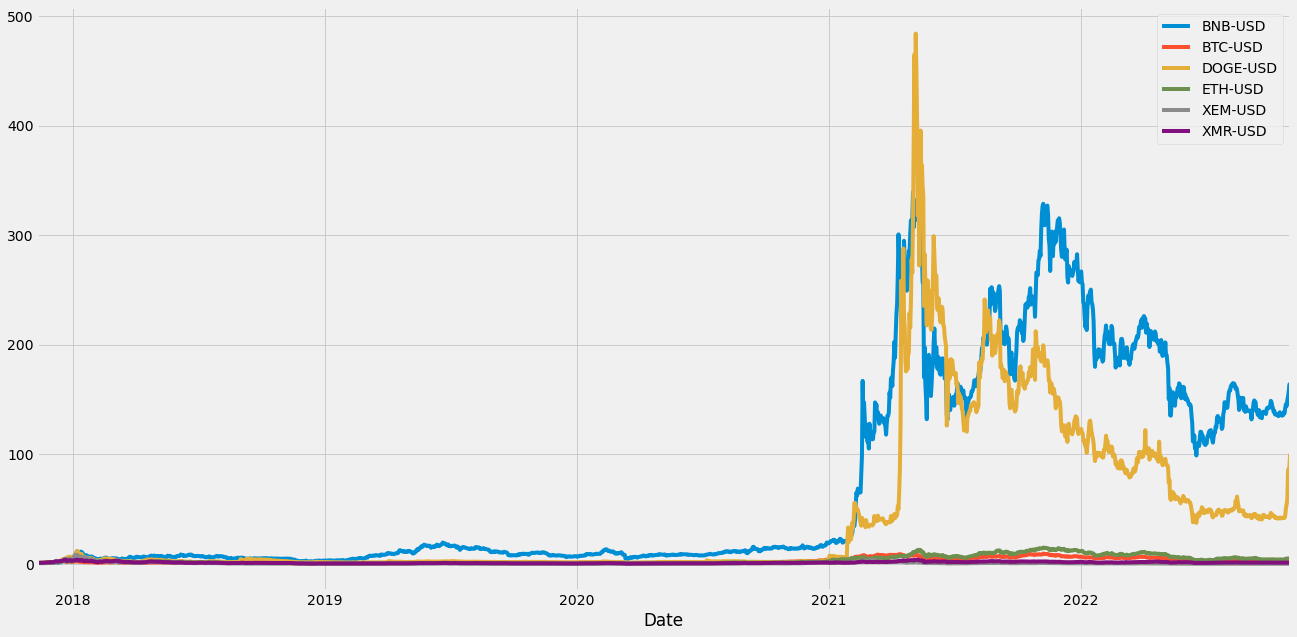

In [371]:
# Plot cumulative returns
cummulative_returns = cumulative_returns.dropna()
cummulative_returns.plot(figsize=(20,10))

### Plot the price change charts as sub-plots

In [372]:
# Drop the daily_change `Close` column index level
daily_change_by_crypto = daily_change.copy()
daily_change_by_crypto.head()

,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,XEM-USD,XMR-USD
Date,,,,,,
2017-11-10,-0.097415,-0.073554,-0.178092,-0.067411,-0.126847,-0.125799
2017-11-11,-0.070329,-0.039368,0.032674,0.051555,-0.002462,0.132877
2017-11-12,-0.090262,-0.064101,-0.135720,-0.021523,-0.062475,0.035447
2017-11-13,0.109845,0.102422,0.166667,0.028606,0.067936,-0.003666
2017-11-14,-0.055757,0.011626,-0.022296,0.066037,0.009379,-0.008501


### Visual inspection the spread of the variability in each currency

In [373]:
daily_change_columns = daily_change_by_crypto.columns
daily_change_by_crypto.hvplot(
    x="Date", 
    y=["BTC-USD", "ETH-USD", "BNB-USD", "DOGE-USD", "XMR-USD", "XEM-USD"], 
    subplots=True
).cols(2)

:NdLayout   [Variable]
   :Curve   [Date]   (value)

### Review the distribution of returns

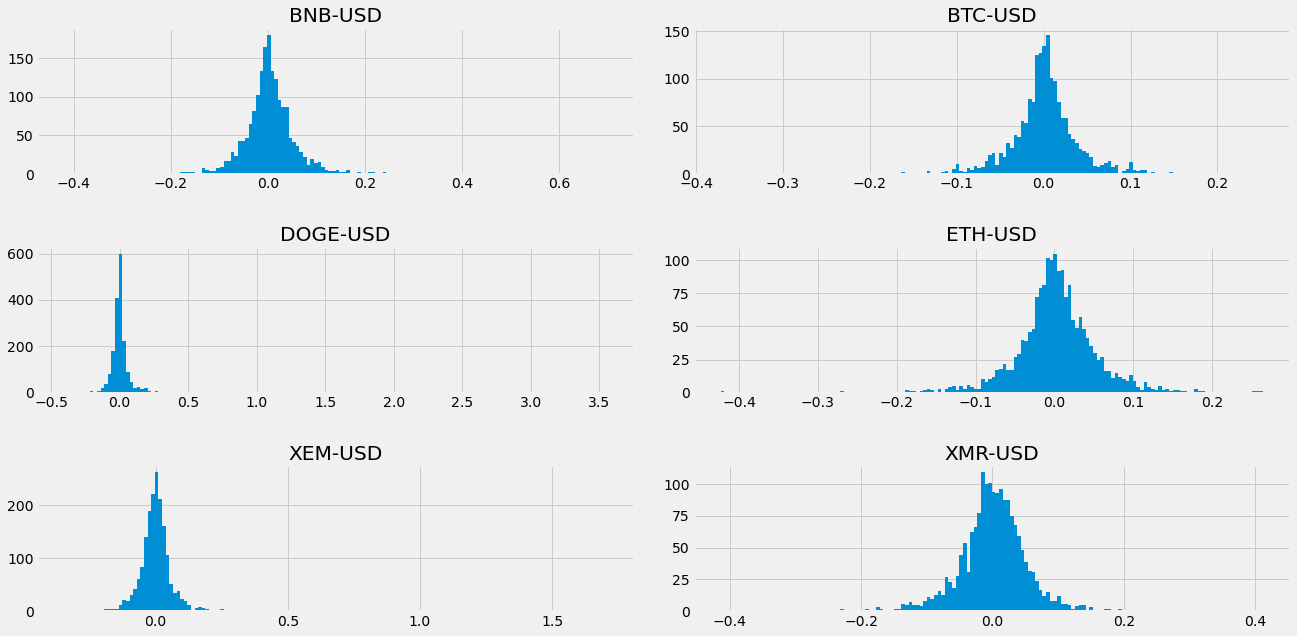

In [374]:
fig, axs = plt.subplots(3, 2, figsize=(20, 10),gridspec_kw={"hspace": 0.5, "wspace": 0.1})
axs = axs.flatten()
i = 0
for crypto in daily_change_by_crypto.columns:
    daily_change_by_crypto[crypto].hist(ax=axs[i], bins=150)
    axs[i].set_title(crypto)
    i += 1

### It is clear that the variability in some currencies is more spread from some than for others

### Checking for outliers

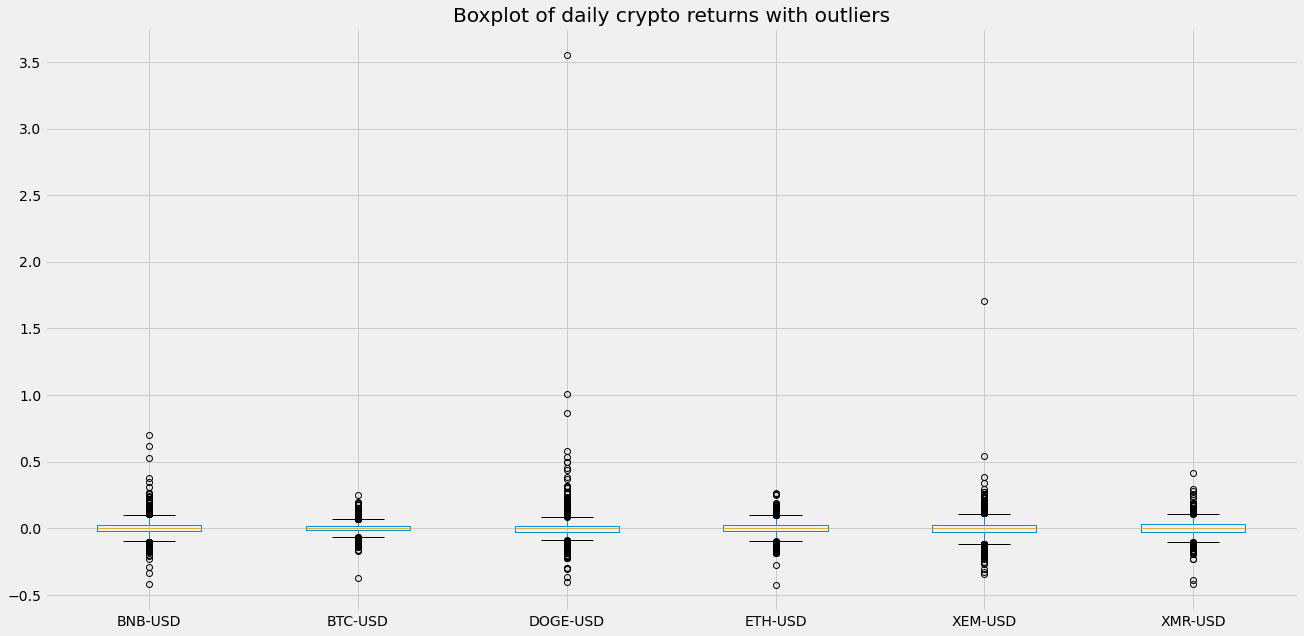

In [375]:
daily_change_by_crypto.boxplot(figsize=(20,10))
plt.title("Boxplot of daily crypto returns with outliers")
plt.show()

### `DOGE` is the most volatile currency with a significant tail

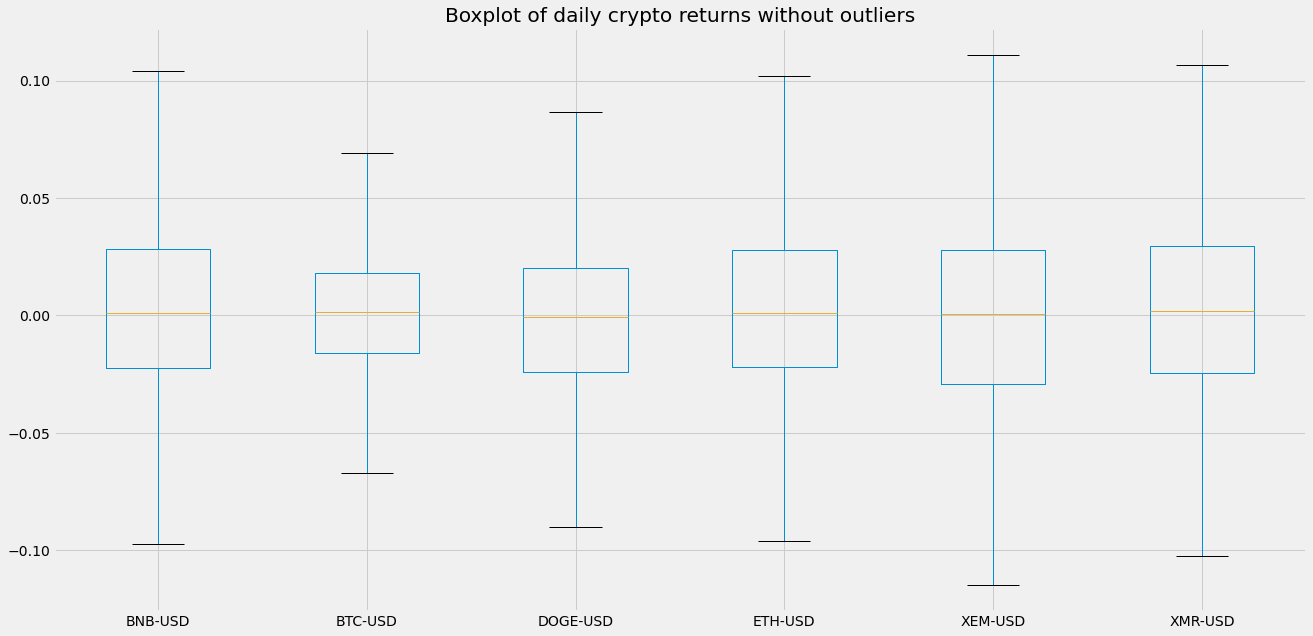

In [376]:
daily_change_by_crypto.boxplot(showfliers=False, figsize=(20,10))
plt.title("Boxplot of daily crypto returns without outliers")
plt.show()

In [377]:
# Calculate the correlation
correlation = daily_change.corr()
correlation

,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,XEM-USD,XMR-USD
BNB-USD,1.000000,0.626788,0.255799,0.614550,0.435685,0.572890
BTC-USD,0.626788,1.000000,0.357196,0.768137,0.457593,0.702377
DOGE-USD,0.255799,0.357196,1.000000,0.326589,0.236346,0.319766
ETH-USD,0.614550,0.768137,0.326589,1.000000,0.544710,0.702193
XEM-USD,0.435685,0.457593,0.236346,0.544710,1.000000,0.468848
XMR-USD,0.572890,0.702377,0.319766,0.702193,0.468848,1.000000


<AxesSubplot:>

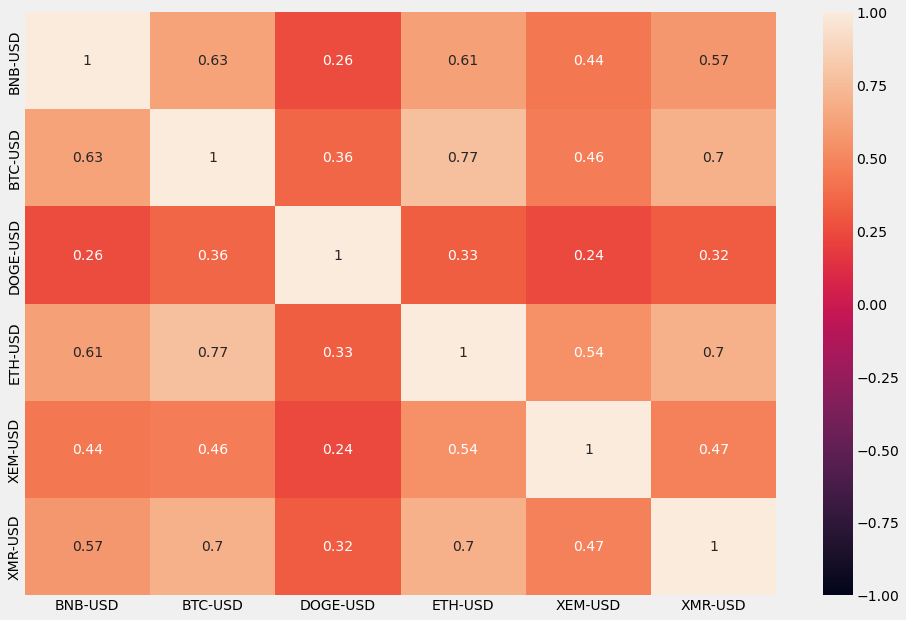

In [378]:
# Display correlation matrix
plt.figure(figsize = (15,10))
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True)

### The above subplots show that each currency operates at dfferent values with `DOGE` having the cheapest prices and `BTC` the most expensive.  There is also higher levels of volatility over the most recent two years.

### We will use facebook's prophet library to forecast directly from the timeseries for each crypto currency for the next 2 months

### We will now split the data into a training dataframe and a testing dataframe that can be using during the forecasting stage
#### Note that given the high degree of volatility associated with crypto currencies, the forecasting will be restricted to a maximum of 2 months

In [444]:
# Get today's date
cut_off_date = date.today()

# Let's make it two months ago 
cut_off_date  = pd.to_datetime(cut_off_date + relativedelta(months = -2))
display(cut_off_date)
training_df = data_df.loc[data_df.index < cut_off_date]
testing_df = data_df.loc[data_df.index >= cut_off_date]

Timestamp('2022-09-01 00:00:00')

In [443]:
# Visualise the two data sets
# training_df.hvplot().opts(title="Training Data") * testing_df.hvplot().opts(title="Testing Data")
training_test_ax = (training_df.hvplot() * testing_df.hvplot()).opts(title="Training / Test Data Set")
training_test_ax * hv.VLine(cut_off_date)

:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .VLine.I      :VLine   [x,y]

In [445]:
# Take a copy of the original dataframe and reset index to convert the date index into a column
training_df = training_df.reset_index()
training_df.tail()

,Date,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,XEM-USD,XMR-USD
1752,2022-08-27,277.801575,20041.738281,0.063587,1491.395020,0.044769,145.055435
1753,2022-08-28,276.250885,19616.814453,0.061786,1430.547363,0.043316,146.422821
1754,2022-08-29,286.221405,20297.994141,0.063887,1553.037354,0.044642,152.634659
1755,2022-08-30,281.425354,19796.808594,0.061525,1523.838867,0.043401,148.695724
1756,2022-08-31,279.238098,20049.763672,0.061330,1553.684937,0.044097,149.027832


In [446]:
model_df = pd.DataFrame()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -36.9244
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3282.87     0.0703665       166.112      0.7645      0.7645      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3339.29    0.00184883       120.642           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3363.64     0.0112402       149.373      0.6905      0.6905      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3380.13    0.00213203       123.858           1           1      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     460       3386.63   0.000333974       155.774   1.672e-06       0.001      593  LS failed, Hessian reset 
     499       3389.29   0.000316177    

/home/gadam/anaconda3/envs/dev/lib/python3.7/site-packages/fbprophet/plot.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -52.9979
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3361.48     0.0198095        225.63           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3460.57    0.00374135       379.271      0.3539      0.8506      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       3481.52   0.000580558       238.188   9.908e-07       0.001      328  LS failed, Hessian reset 
     299       3494.23    0.00140381       288.269      0.2046      0.2046      402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318       3495.74    0.00023446       118.177   1.051e-06       0.001      467  LS failed, Hessian reset 
     357       3499.53    0.00115328       226.134   7.484e-06       0.001      555  LS failed, Hessian rese

/home/gadam/anaconda3/envs/dev/lib/python3.7/site-packages/fbprophet/plot.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -19.4145
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3901.73     0.0351273       823.373           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3974.35     0.0360616       772.821           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       3991.93    0.00028877        272.13   7.423e-07       0.001      288  LS failed, Hessian reset 
     299       4030.47    0.00934547       712.387      0.1758           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4049.65    0.00760975       291.345           1           1      498   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4095.47    0.00345779    

/home/gadam/anaconda3/envs/dev/lib/python3.7/site-packages/fbprophet/plot.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -42.0853
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3494.26     0.0252758       282.544           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3585.87     0.0257155       938.862           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3633.54    0.00491166       313.523      0.2729      0.2729      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3658.07     0.0111718       148.053      0.2349           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     401       3658.19    0.00025595       159.171   1.038e-06       0.001      506  LS failed, Hessian reset 
     499       3662.12   0.000183812    

/home/gadam/anaconda3/envs/dev/lib/python3.7/site-packages/fbprophet/plot.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -12.5075
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3819.45   0.000590538       327.786      0.4448      0.4448      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3835.86    0.00379972       136.705           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3841.39   0.000870846       134.131      0.2966      0.8658      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3845.01    0.00377091       152.515           1           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     423        3847.9   0.000394785        131.09   7.044e-07       0.001      555  LS failed, Hessian reset 
     474       3849.91   0.000123905    

/home/gadam/anaconda3/envs/dev/lib/python3.7/site-packages/fbprophet/plot.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -32.567
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3437.32     0.0565464       291.388           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       3455.49   0.000743716       330.584   2.125e-06       0.001      249  LS failed, Hessian reset 
     199       3456.62    0.00273292       333.165       0.922       0.922      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       3459.32   0.000340547       172.719   2.305e-06       0.001      366  LS failed, Hessian reset 
     299       3460.43    0.00123793       60.7702      0.2055           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3466.96    0.00770621        365.68           1           1      529   
    Iter      log prob

/home/gadam/anaconda3/envs/dev/lib/python3.7/site-packages/fbprophet/plot.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


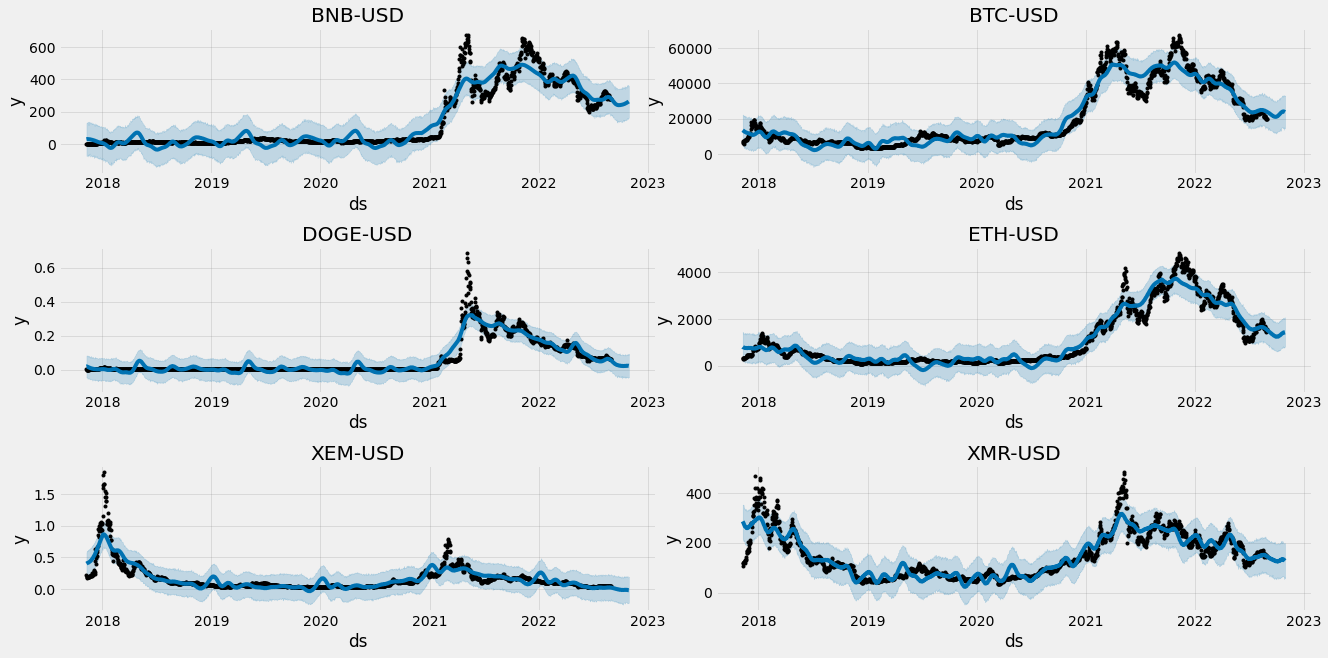

In [447]:
fig, axs = plt.subplots(3, 2, figsize=(20, 10),gridspec_kw={"hspace": 0.5, "wspace": 0.1})
axs = axs.flatten()
i = 0
for crypto in training_df.columns:
    if crypto == "Date":
        continue
    model_df[["ds", "y"]] = training_df[["Date", crypto]]
    # Initialise the model with 95% confidence interval
    model = Prophet(interval_width=0.95)
    # Train the model
    model.fit(model_df)
    # Create a future forecast
    future_df = model.make_future_dataframe(periods=60, freq="D")
    # Predict the future closing price
    forecast_df = model.predict(future_df)
    # Add the plot to the subplot set
    model.plot(forecast_df, ax=axs[i])
    axs[i].set_title(crypto)
    axs[i].xlabel="Year"
    del model
    i += 1

### Plot the original dataframe for comparison

In [448]:
training_df.hvplot(
    x="Date", 
    y=["BNB-USD", "BTC-USD", "DOGE-USD", "ETH-USD", "XEM-USD", "XMR-USD"], 
    subplots=True,
    shared_axes=False
).cols(2)

:NdLayout   [Variable]
   :Curve   [Date]   (value)

In [383]:
data_df.loc['2021-12-31']

BNB-USD       511.708313
BTC-USD     46306.445312
DOGE-USD        0.170496
ETH-USD      3682.632812
XEM-USD         0.122864
XMR-USD       228.824951
Name: 2021-12-31 00:00:00, dtype: float64

### Examining the trends for a two of the currencies: `BTC` and `ETH`

In [384]:
# Training the model on BTC
model_df[["ds", "y"]] = crypto_data_df[["Date", "BTC-USD"]]
model = pd.DataFrame

# Initialise the model with 95% confidence interval and train it
model = Prophet(interval_width=0.95)
model.fit(model_df)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -52.9559


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3552.67     0.0653188       351.552           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       3614.72   0.000504699       218.655   9.573e-07       0.001      216  LS failed, Hessian reset 
     199       3665.14     0.0190217       485.036      0.4263           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3726.6    0.00634346       166.182           1           1      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3772.05      0.145318       492.401           1           1      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3806.75     0.0150104       264.044           1           1      6

In [385]:
# Forecasting for BTC
future_df = model.make_future_dataframe(periods=60, freq="D")
display(future_df.head())
display(future_df.tail())

,ds
0,2017-11-09
1,2017-11-10
2,2017-11-11
3,2017-11-12
4,2017-11-13


,ds
1874,2022-12-27
1875,2022-12-28
1876,2022-12-29
1877,2022-12-30
1878,2022-12-31


In [386]:
forecast_df = model.predict(future_df)
display(forecast_df[["ds", "yhat"]].head())
display(forecast_df[["ds", "yhat"]].tail())

,ds,yhat
0,2017-11-09,14097.697727
1,2017-11-10,13936.693638
2,2017-11-11,13794.523030
3,2017-11-12,13620.226144
4,2017-11-13,13494.632069


,ds,yhat
1874,2022-12-27,7154.716288
1875,2022-12-28,7222.996940
1876,2022-12-29,7137.244502
1877,2022-12-30,7162.122286
1878,2022-12-31,7186.961543


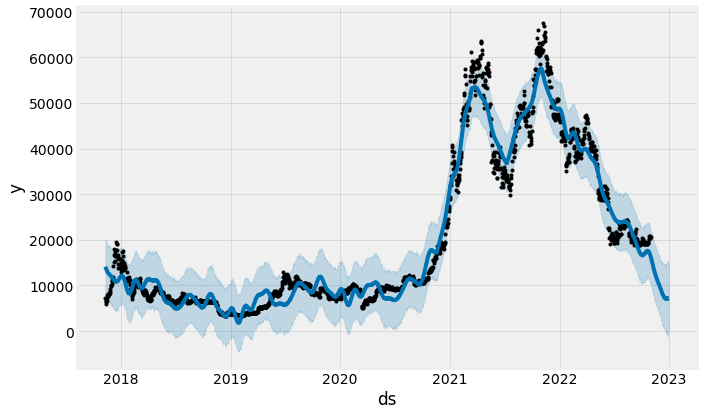

In [387]:
# Visualise the predictions
btx_ax_forecast = model.plot(forecast_df)

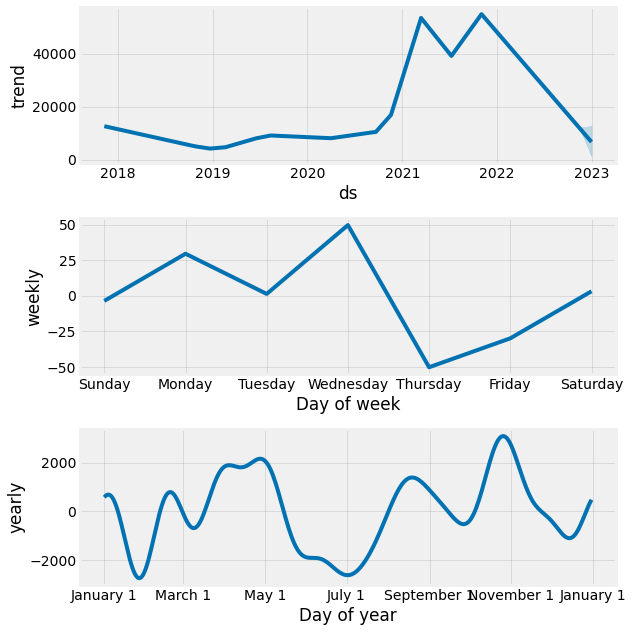

In [388]:
# Reviewing the components for the currency
btc_ax = model.plot_components(forecast_df)


### Check the above result for BTC-USD by limiting the training dataset to the end of 2020, then comparing the Prophet forecast for 2021 to Actuals for the end of 2021

In [389]:
# Create a training dataset that ends 31/12/2021
hist_df = crypto_data_df[pd.to_datetime(crypto_data_df["Date"]) < "2021-01-01"]
btc_model_df = pd.DataFrame()  # Instantiate a new dataframe
btc_model_df[["ds", "y"]] = hist_df[["Date", "BTC-USD"]]
btc_model_df.tail()

,ds,y
1144,2020-12-27,26272.294922
1145,2020-12-28,27084.808594
1146,2020-12-29,27362.437500
1147,2020-12-30,28840.953125
1148,2020-12-31,29001.720703


In [390]:
model = Prophet(interval_width=0.95)
model.fit(btc_model_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -85.7914


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2584.53      0.023228       191.003           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2623.66      0.002183       147.927      0.9232      0.9232      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2637.87     0.0488115       192.234           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2654.53    0.00757383       171.949           1           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        2657.8    0.00680498       288.524           1           1      610   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [391]:
future_df = model.make_future_dataframe(periods=365, freq="D")

In [392]:
forecast_df = model.predict(future_df)
forecast_df[["ds", "yhat"]].tail()

,ds,yhat
1509,2021-12-27,36954.621526
1510,2021-12-28,36964.075511
1511,2021-12-29,36996.233058
1512,2021-12-30,36962.676226
1513,2021-12-31,36936.542849


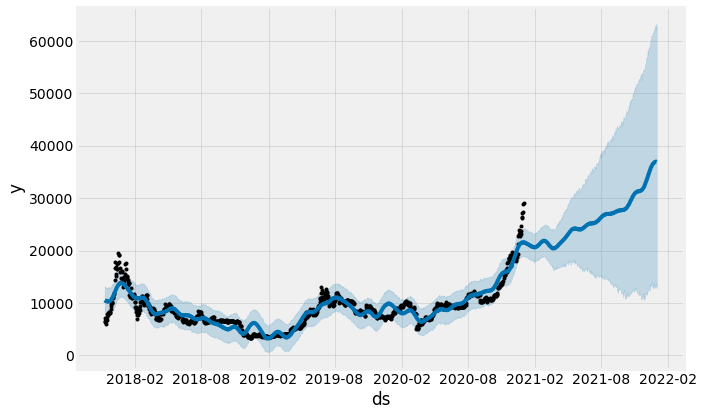

In [393]:
model.plot(forecast_df)
plt.show()

### Compare to the actual price of BTC-USD on 31/12/2021

In [394]:
forecast_df.loc[forecast_df['ds'] == '2021-12-31']

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1513,2021-12-31,33499.495243,12771.632964,62854.872716,9332.0484,59318.895546,3437.047606,3437.047606,3437.047606,-30.888779,-30.888779,-30.888779,3467.936385,3467.936385,3467.936385,0.0,0.0,0.0,36936.542849


In [395]:
display(f"The original BTC closing price was ${data_df.loc['2021-12-31']['BTC-USD']:0.2f} compared to the forecast of ${forecast_df.loc[forecast_df['ds'] == '2021-12-31']['yhat'].values[0]:0.2f} which fits within the confidence interval range of ${forecast_df.loc[forecast_df['ds'] == '2021-12-31']['yhat_lower'].values[0]:0.2f} to ${forecast_df.loc[forecast_df['ds'] == '2021-12-31']['yhat_upper'].values[0]:0.2f}")


'The original BTC closing price was $46306.45 compared to the forecast of $36936.54 which fits within the confidence interval range of $12771.63 to $62854.87'

In [396]:
data_df.loc['2021-12-31']

BNB-USD       511.708313
BTC-USD     46306.445312
DOGE-USD        0.170496
ETH-USD      3682.632812
XEM-USD         0.122864
XMR-USD       228.824951
Name: 2021-12-31 00:00:00, dtype: float64

### Will now repeat this exercise and compare the Ethereum forecast

In [397]:
eth_model_df = pd.DataFrame()  # Instantiate a new dataframe
eth_model_df[["ds", "y"]] = hist_df[["Date", "ETH-USD"]]
eth_model_df.head()

,ds,y
0,2017-11-09,320.884003
1,2017-11-10,299.252991
2,2017-11-11,314.681000
3,2017-11-12,307.907990
4,2017-11-13,316.716003


In [398]:
del model  # Release the object before reusing it
model = Prophet(interval_width=0.95)
model.fit(eth_model_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -39.8274
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2473.23     0.0126817       848.231           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2529.59     0.0609948       646.396           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2582.94     0.0172192       343.033       7.874      0.7874      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2616.12    0.00480211       277.974           1           1      480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2639.84     0.0241919       157.396           1           1      603   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [399]:
future_df = model.make_future_dataframe(periods=365, freq="D")

In [400]:
forecast_df = model.predict(future_df)
forecast_df.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1509,2021-12-27,1292.306794,-87.302691,2648.149804,-133.593394,2613.688045,37.551428,37.551428,37.551428,1.417351,1.417351,1.417351,36.134077,36.134077,36.134077,0.0,0.0,0.0,1329.858221
1510,2021-12-28,1294.175846,-42.674125,2697.770404,-137.846508,2619.212652,43.620669,43.620669,43.620669,0.699317,0.699317,0.699317,42.921352,42.921352,42.921352,0.0,0.0,0.0,1337.796515
1511,2021-12-29,1296.044898,-113.103692,2679.556309,-142.099622,2624.249395,48.733149,48.733149,48.733149,-1.194727,-1.194727,-1.194727,49.927876,49.927876,49.927876,0.0,0.0,0.0,1344.778047
1512,2021-12-30,1297.913949,-97.563846,2708.979627,-146.352735,2630.454871,54.581170,54.581170,54.581170,-2.511810,-2.511810,-2.511810,57.092981,57.092981,57.092981,0.0,0.0,0.0,1352.495120
1513,2021-12-31,1299.783001,-60.358009,2708.427954,-150.605849,2638.552693,62.397724,62.397724,62.397724,-1.951320,-1.951320,-1.951320,64.349044,64.349044,64.349044,0.0,0.0,0.0,1362.180725


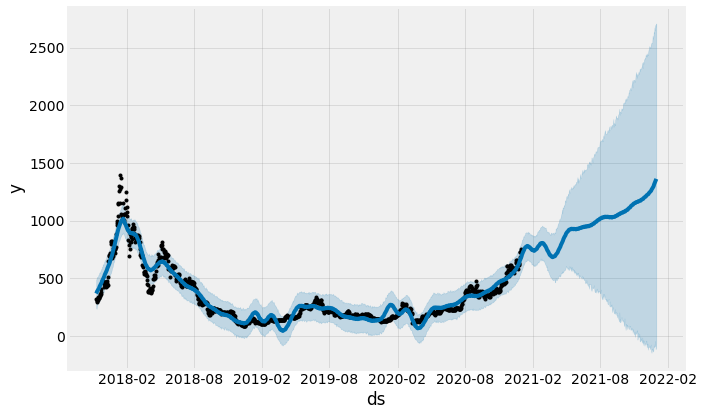

In [401]:
model.plot(forecast_df)
plt.show()

In [402]:
eth_closing_price_2021 = data_df.loc["2021-12-31"]["ETH-USD"]
eth_closing_price_2021
display(f"The original ETH closing price was ${data_df.loc['2021-12-31']['ETH-USD']:0.2f} compared to the forecast of ${forecast_df.loc[forecast_df['ds'] == '2021-12-31']['yhat'].values[0]:0.2f} which is outside the confidence interval range of ${forecast_df.loc[forecast_df['ds'] == '2021-12-31']['yhat_lower'].values[0]:0.2f} to ${forecast_df.loc[forecast_df['ds'] == '2021-12-31']['yhat_upper'].values[0]:0.2f}")


'The original ETH closing price was $3682.63 compared to the forecast of $1362.18 which is outside the confidence interval range of $-60.36 to $2708.43'

### Examining the trends

### Get economic data

In [38]:
# Set observation start date
start_date = "2018/01/01"

In [39]:
# Retrieve API keys
load_dotenv()
fred_api_key = os.getenv("FRED_API_KEY")
if not(fred_api_key):
    print("Failed to load API credentials")

In [40]:
fred = Fred(api_key=fred_api_key)
sp500 = fred.get_series("SP500", observation_start=start_date)

In [41]:
display(sp500.head())
display(sp500.tail())

2018-01-01        NaN
2018-01-02    2695.81
2018-01-03    2713.06
2018-01-04    2723.99
2018-01-05    2743.15
dtype: float64

2022-10-25    3859.11
2022-10-26    3830.60
2022-10-27    3807.30
2022-10-28    3901.06
2022-10-31    3871.98
dtype: float64

In [42]:
sp500 = sp500.dropna().copy()

<AxesSubplot:title={'center':'S&P 500'}>

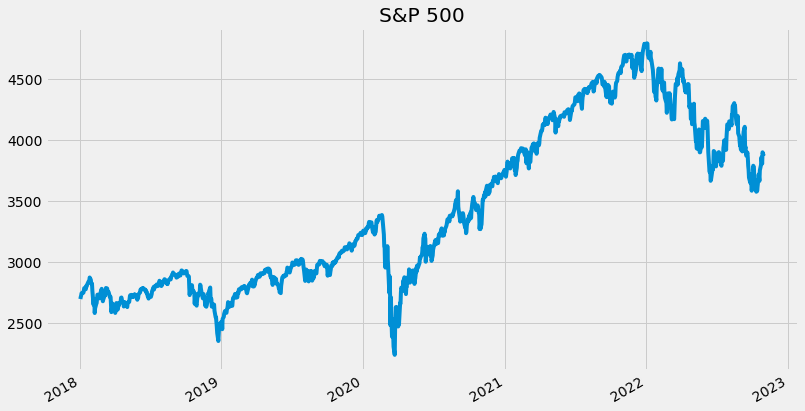

In [43]:
sp500.plot(figsize=(12, 7), title="S&P 500")

### Get unemployment data

In [44]:
# Seasonally adjusted
unemployment_df = fred.get_series("UNRATE", observation_start=start_date)

In [45]:
display(unemployment_df.head())
display(unemployment_df.tail())

2018-01-01    4.0
2018-02-01    4.1
2018-03-01    4.0
2018-04-01    4.0
2018-05-01    3.8
dtype: float64

2022-05-01    3.6
2022-06-01    3.6
2022-07-01    3.5
2022-08-01    3.7
2022-09-01    3.5
dtype: float64

In [46]:
unemployment_df.isna().sum()

0

<AxesSubplot:title={'center':'US Unemployment Rate'}>

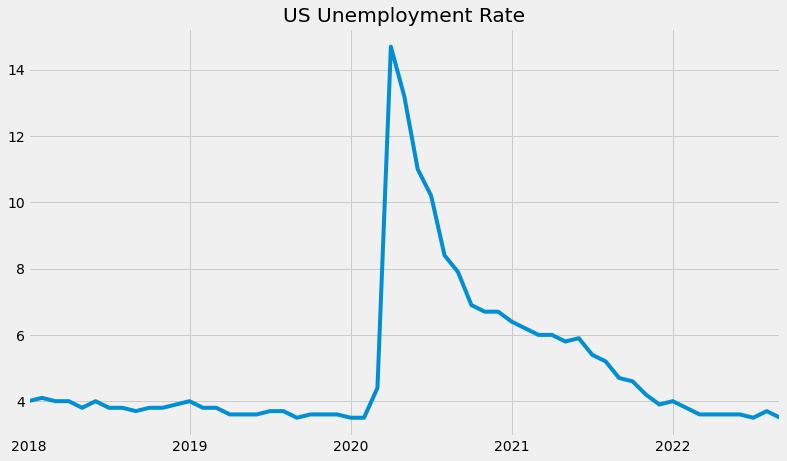

In [47]:
unemployment_df.plot(figsize=(12, 7), title="US Unemployment Rate")

### Search for CPI data

In [48]:
cpi_df = fred.get_series("CPIAUCSL", observation_start=start_date)

In [49]:
display(cpi_df.head())
display(cpi_df.tail())

2018-01-01    248.743
2018-02-01    249.439
2018-03-01    249.581
2018-04-01    250.146
2018-05-01    250.779
dtype: float64

2022-05-01    291.474
2022-06-01    295.328
2022-07-01    295.271
2022-08-01    295.620
2022-09-01    296.761
dtype: float64

In [50]:
cpi_df.isna().sum()

0

<AxesSubplot:title={'center':'US Consumer Price Index'}>

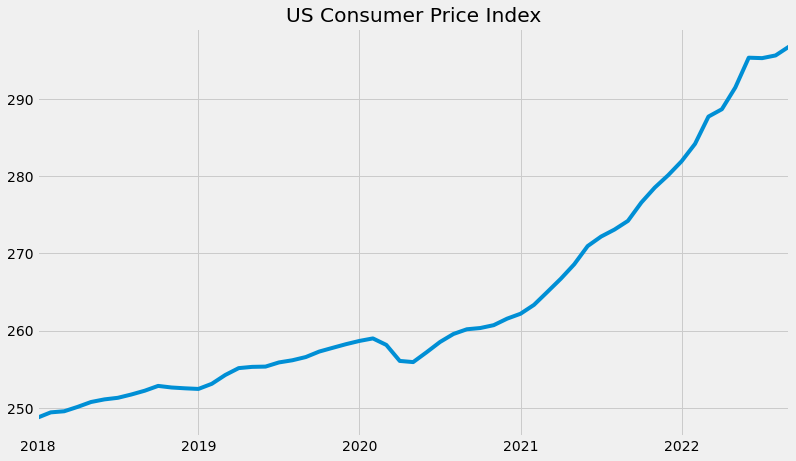

In [51]:
cpi_df.plot(figsize=(12, 7), title="US Consumer Price Index")

### Get GDP

In [52]:
gdp_df = fred.get_series("GDPC1", observation_start=start_date)

In [53]:
display(gdp_df.head())
display(gdp_df.tail())

2018-01-01    18437.127
2018-04-01    18565.697
2018-07-01    18699.748
2018-10-01    18733.741
2019-01-01    18835.411
dtype: float64

2021-07-01    19672.594
2021-10-01    20006.181
2022-01-01    19924.088
2022-04-01    19895.271
2022-07-01    20021.721
dtype: float64

In [54]:
gdp_df.isna().sum()

0

<AxesSubplot:title={'center':'US Real Gross Domestic Product'}>

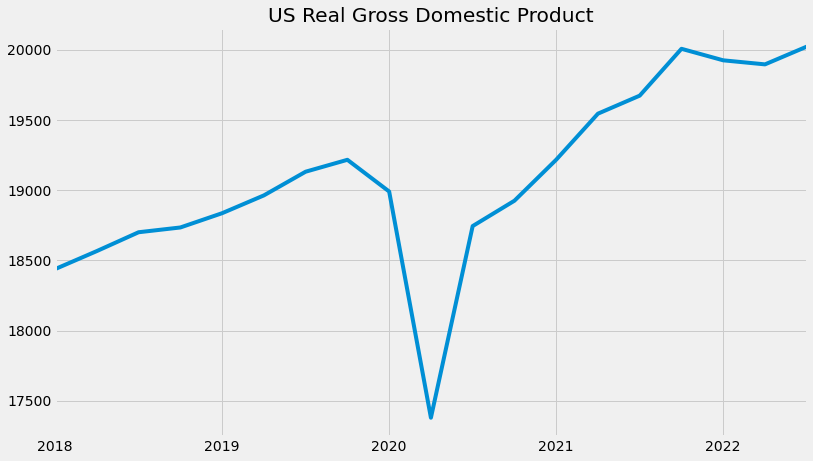

In [55]:
gdp_df.plot(figsize=(12, 7), title="US Real Gross Domestic Product")

### US Interest rates

In [56]:
int_df = fred.get_series("DFF", observation_start=start_date)

In [57]:
display(int_df.head())
display(int_df.tail())

2018-01-01    1.33
2018-01-02    1.42
2018-01-03    1.42
2018-01-04    1.42
2018-01-05    1.42
dtype: float64

2022-10-24    3.08
2022-10-25    3.08
2022-10-26    3.08
2022-10-27    3.08
2022-10-28    3.08
dtype: float64

In [58]:
int_df.isna().sum()

0

<AxesSubplot:title={'center':'US Federal Reserve Effective Rate'}>

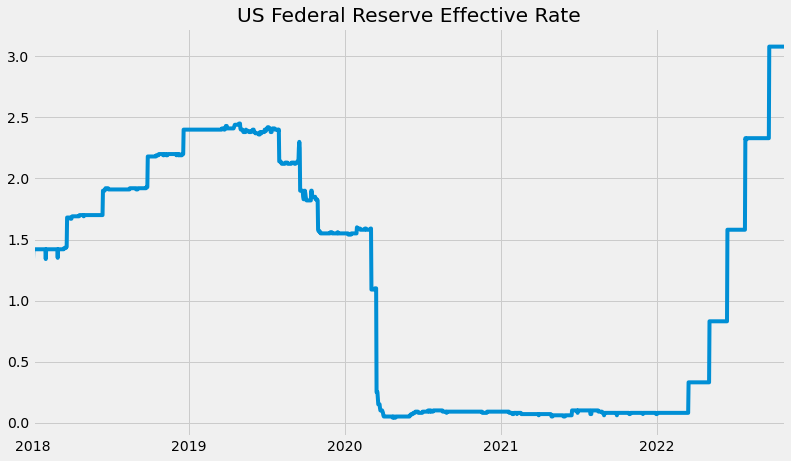

In [59]:
int_df.plot(figsize=(12, 7), title="US Federal Reserve Effective Rate")

### Unemployment benefit claims

In [60]:
unemployment_claims_df = fred.get_series("ICSA", observation_start=start_date)

In [61]:
display(unemployment_claims_df.head())
display(unemployment_claims_df.tail())

2018-01-06    252000.0
2018-01-13    224000.0
2018-01-20    227000.0
2018-01-27    223000.0
2018-02-03    213000.0
dtype: float64

2022-09-24    190000.0
2022-10-01    219000.0
2022-10-08    226000.0
2022-10-15    214000.0
2022-10-22    217000.0
dtype: float64

In [62]:
unemployment_claims_df.isna().sum()

0

<AxesSubplot:title={'center':'US Weekly Unemployment Insurance Claims'}>

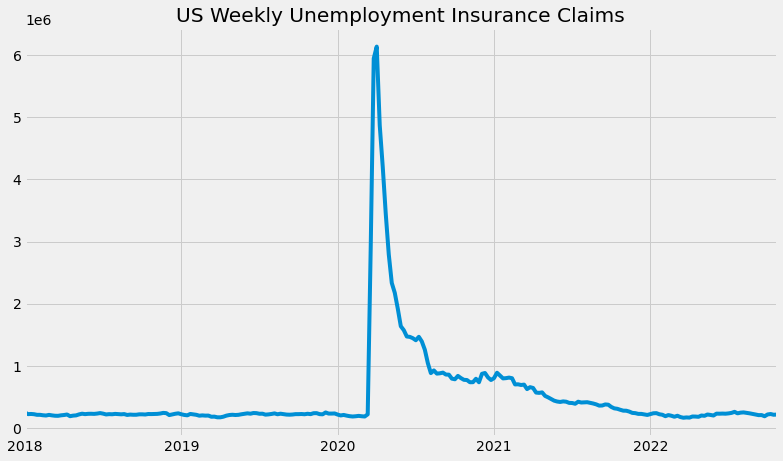

In [63]:
unemployment_claims_df.plot(figsize=(12, 7), title="US Weekly Unemployment Insurance Claims")

### Get labour force participation

In [64]:
labour_df = fred.get_series("CIVPART", observation_start=start_date)

In [65]:
display(labour_df.head())
display(labour_df.tail())

2018-01-01    62.7
2018-02-01    63.0
2018-03-01    62.9
2018-04-01    62.9
2018-05-01    62.9
dtype: float64

2022-05-01    62.3
2022-06-01    62.2
2022-07-01    62.1
2022-08-01    62.4
2022-09-01    62.3
dtype: float64

In [66]:
labour_df.isna().sum()

0

<AxesSubplot:title={'center':'US Labour Force Participation'}>

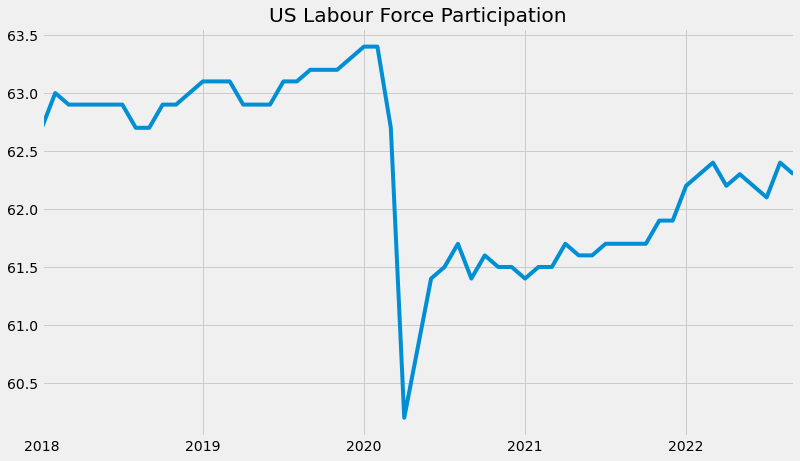

In [67]:
labour_df.plot(figsize=(12, 7), title="US Labour Force Participation")

### Collect economic data into merged visualisation

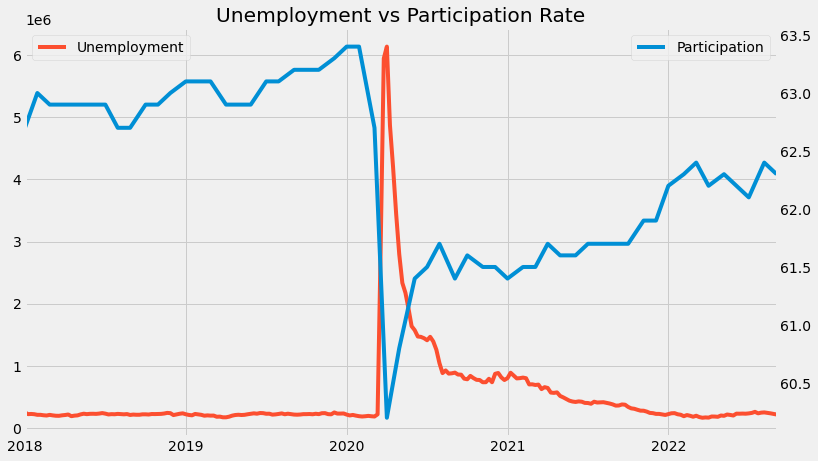

In [68]:
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
unemployment_claims_df.plot(ax=ax, label="Unemployment", color=color_pal[1])
labour_df.plot(ax=ax2, label="Participation", color=color_pal[0])
ax2.grid(False)
ax.set_title("Unemployment vs Participation Rate")
ax.legend(loc="upper left")
ax2.legend()

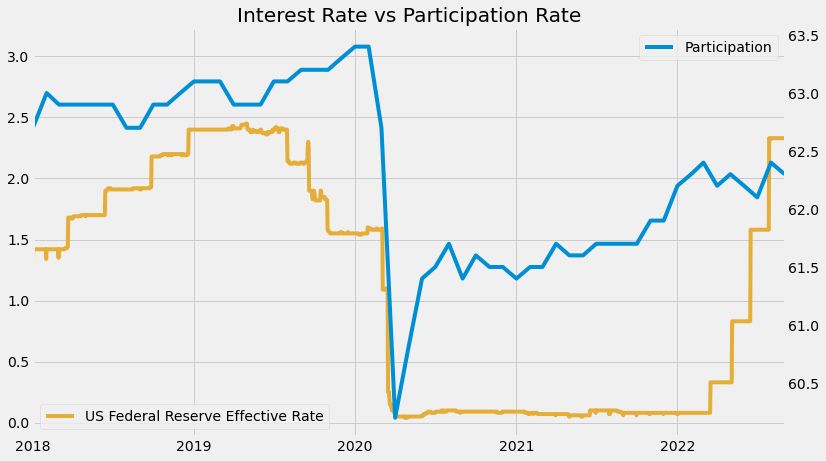

In [69]:
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
int_df.plot(ax=ax, label="US Federal Reserve Effective Rate", color=color_pal[2])
labour_df.plot(ax=ax2, label="Participation", color=color_pal[0])
ax2.grid(False)
ax.set_title("Interest Rate vs Participation Rate")
ax.legend(loc="lower left")
ax2.legend()

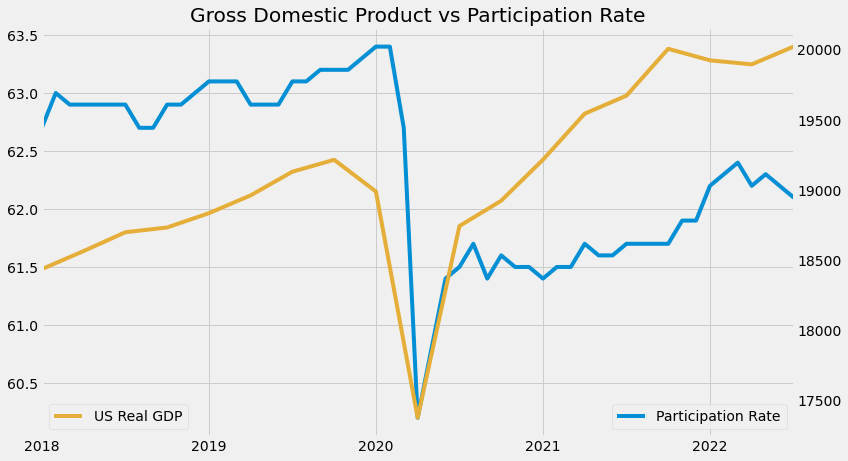

In [70]:
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
labour_df.plot(ax=ax, label="Participation Rate", color=color_pal[0])
gdp_df.plot(ax=ax2, label="US Real GDP", color=color_pal[2])
ax2.grid(False)
ax.set_title("Gross Domestic Product vs Participation Rate")
ax.legend(loc="lower right")
ax2.legend(loc="lower left")

### Get the global price of energy

In [71]:
energy_df = fred.get_series("PNRGINDEXM", observation_start=start_date)
display(energy_df.head())
display(energy_df.tail())

2018-01-01    152.812740
2018-02-01    147.221808
2018-03-01    147.282110
2018-04-01    151.756234
2018-05-01    162.898255
dtype: float64

2022-04-01    300.533178
2022-05-01    306.674979
2022-06-01    328.123480
2022-07-01    343.809997
2022-08-01    376.412083
dtype: float64

In [72]:
energy_df.isna().sum()

0

<AxesSubplot:title={'center':'Global Energy Prices'}, ylabel='Index'>

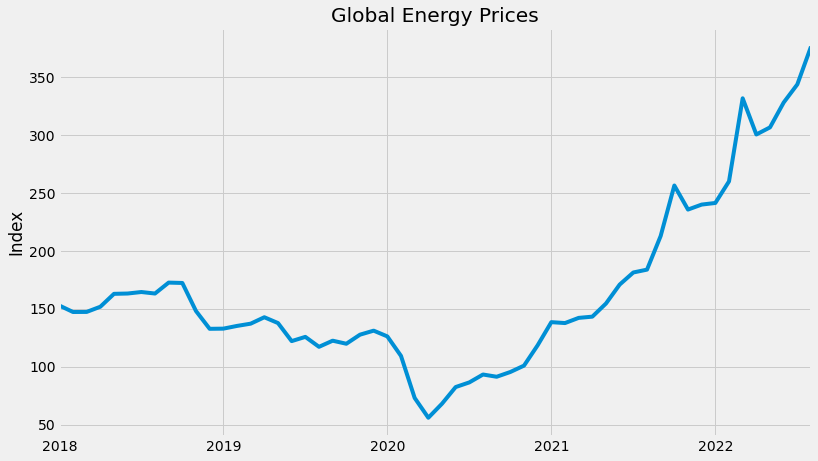

In [73]:
energy_df.plot(
    figsize=(12, 7), 
    title="Global Energy Prices",
    ylabel="Index"
)

### Looking at the economic uncertainty index of the *United States*

In [74]:
us_econ_df = fred.get_series("PNRGINDEXM", observation_start=start_date)
display(us_econ_df.head())
display(us_econ_df.tail())

2018-01-01    152.812740
2018-02-01    147.221808
2018-03-01    147.282110
2018-04-01    151.756234
2018-05-01    162.898255
dtype: float64

2022-04-01    300.533178
2022-05-01    306.674979
2022-06-01    328.123480
2022-07-01    343.809997
2022-08-01    376.412083
dtype: float64

In [75]:
us_econ_df.isna().sum()

0

Text(-80, -20, 'Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Economic Policy Uncertainty Index for United States [USEPUINDXD], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/USEPUINDXD, October 28, 2022.')

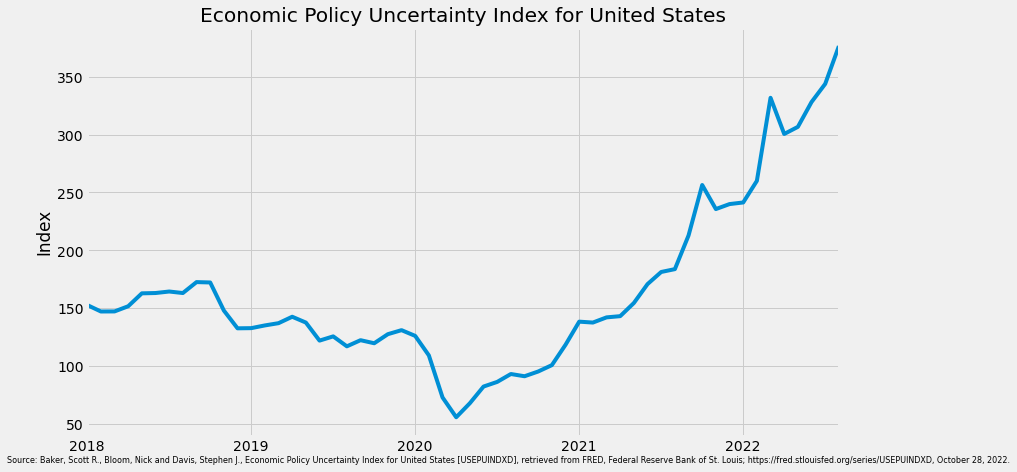

In [76]:
annotation = "Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Economic Policy Uncertainty Index for United States [USEPUINDXD], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/USEPUINDXD, October 28, 2022."
plt_us_econ = us_econ_df.plot(
    figsize=(12, 7), 
    title="Economic Policy Uncertainty Index for United States",
    ylabel="Index"
)
plt_us_econ.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")

### World uncertainty index for United States

In [77]:
us_uncertainty_df = fred.get_series("WUIUSA", observation_start=start_date)
display(us_uncertainty_df.head())
display(us_uncertainty_df.tail())

2018-01-01    0.000000
2018-04-01    0.210544
2018-07-01    0.307740
2018-10-01    0.250831
2019-01-01    0.480637
dtype: float64

2021-07-01    0.154528
2021-10-01    0.120839
2022-01-01    0.199144
2022-04-01    0.170571
2022-07-01    0.170629
dtype: float64

In [78]:
us_uncertainty_df.isna().sum()

0

Text(-80, -20, 'Source: Ahir, Hites, Bloom, Nick and Furceri, Davide, World Uncertainty Index for United States [WUIUSA], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/WUIUSA, October 28, 2022.')

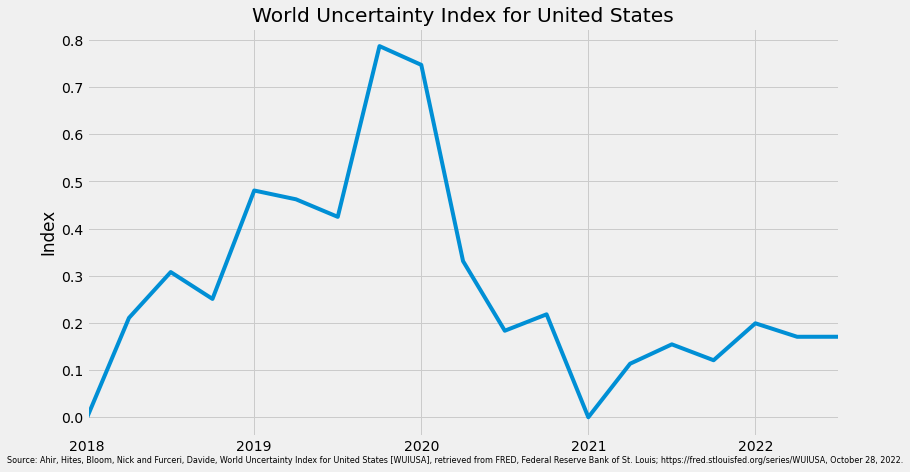

In [79]:
annotation = "Source: Ahir, Hites, Bloom, Nick and Furceri, Davide, World Uncertainty Index for United States [WUIUSA], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/WUIUSA, October 28, 2022."
plt_us_uncertainty = us_uncertainty_df.plot(
    figsize=(12, 7), 
    title="World Uncertainty Index for United States",
    ylabel="Index"
)
plt_us_uncertainty.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")

### Comparing the policy uncertainty and world uncertainty indices for the United States

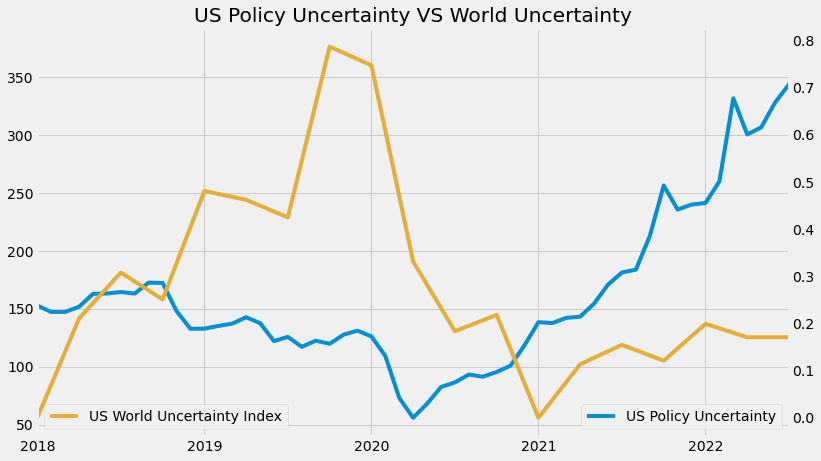

In [80]:
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
us_econ_df.plot(ax=ax, label="US Policy Uncertainty", color=color_pal[0])
us_uncertainty_df.plot(ax=ax2, label="US World Uncertainty Index", color=color_pal[2])
ax2.grid(False)
ax.set_title("US Policy Uncertainty VS World Uncertainty")
ax.legend(loc="lower right")
ax2.legend(loc="lower left")

### European economic uncertainty

In [81]:
eu_econ_df = fred.get_series("EUEPUINDXM", observation_start=start_date)
display(eu_econ_df.head())
display(eu_econ_df.tail())

2018-01-01    196.43605
2018-02-01    135.16371
2018-03-01    175.57617
2018-04-01    150.18456
2018-05-01    224.51605
dtype: float64

2022-05-01    328.47522
2022-06-01    332.62823
2022-07-01    403.90579
2022-08-01    327.56512
2022-09-01    371.58771
dtype: float64

In [82]:
eu_econ_df.isna().sum()

0

Text(-80, -20, 'Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Economic Policy Uncertainty Index for Europe [EUEPUINDXM], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/EUEPUINDXM, October 28, 2022.')

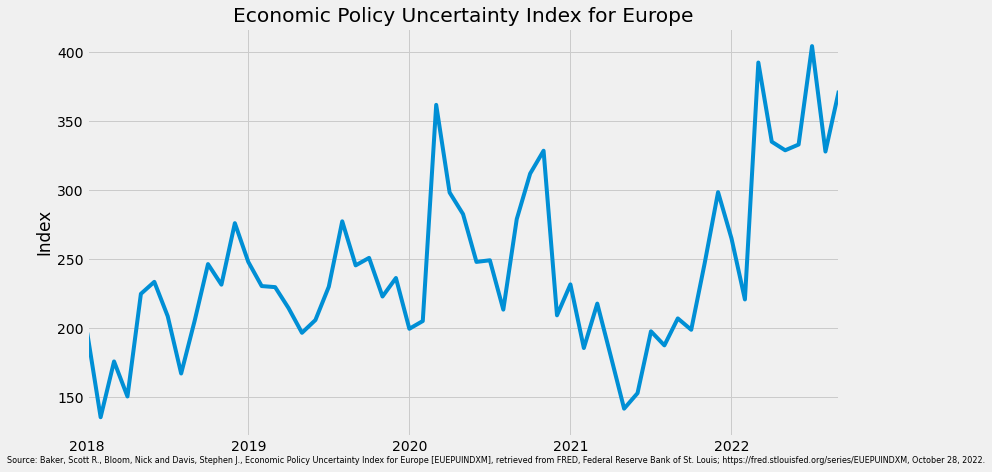

In [83]:
annotation = "Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Economic Policy Uncertainty Index for Europe [EUEPUINDXM], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/EUEPUINDXM, October 28, 2022."
plt_eu_econ = eu_econ_df.plot(
    figsize=(12, 7), 
    title="Economic Policy Uncertainty Index for Europe",
    ylabel="Index"
)
plt_eu_econ.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")

### Economic policy uncertainty index for China

In [84]:
ch_econ_df = fred.get_series("CHIEPUINDXM", observation_start=start_date)
display(ch_econ_df.head())
display(ch_econ_df.tail())

2018-01-01    122.93740
2018-02-01    211.78018
2018-03-01    245.55171
2018-04-01    291.30698
2018-05-01    374.10382
dtype: float64

2018-12-01    935.31030
2019-01-01    654.96265
2019-02-01    720.15790
2019-03-01    753.10773
2019-04-01    502.55005
dtype: float64

In [85]:
ch_econ_df.isna().sum()

0

Text(-80, -20, 'Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Economic Policy Uncertainty Index for China [CHIEPUINDXM], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CHIEPUINDXM, October 28, 2022.')

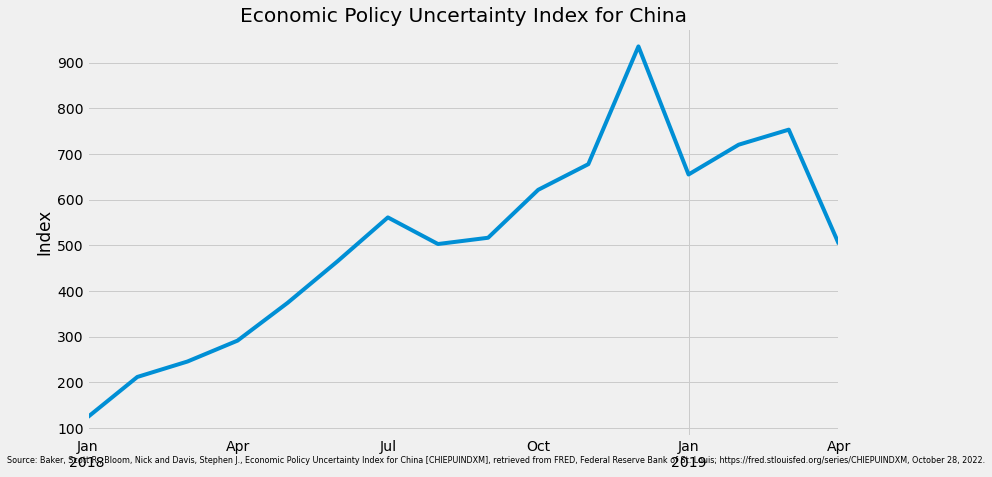

In [86]:
annotation = "Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Economic Policy Uncertainty Index for China [CHIEPUINDXM], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CHIEPUINDXM, October 28, 2022."
plt_ch_econ = ch_econ_df.plot(
    figsize=(12, 7), 
    title="Economic Policy Uncertainty Index for China",
    ylabel="Index"
)
plt_ch_econ.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")

### Equity market volatility - commodity markets

In [87]:
commodity_df = fred.get_series("EMVCOMMMKT", observation_start=start_date)
display(commodity_df.head())
display(commodity_df.tail())

2018-01-01     7.08699
2018-02-01    10.79867
2018-03-01     9.83779
2018-04-01     9.04891
2018-05-01     7.01640
dtype: float64

2022-04-01     8.56844
2022-05-01    13.17406
2022-06-01     7.02604
2022-07-01    10.19806
2022-08-01     6.08326
dtype: float64

In [88]:
commodity_df.isna().sum()

0

Text(-80, -20, 'Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Equity Market Volatility Tracker: Commodity Markets [EMVCOMMMKT], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/EMVCOMMMKT, October 28, 2022.')

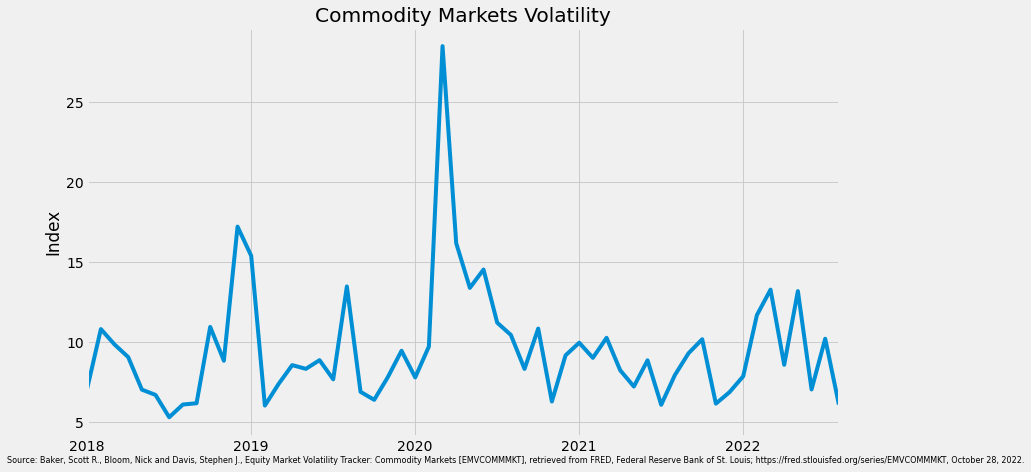

In [89]:
annotation = "Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Equity Market Volatility Tracker: Commodity Markets [EMVCOMMMKT], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/EMVCOMMMKT, October 28, 2022."
plt_commodity = commodity_df.plot(
    figsize=(12, 7), 
    title="Commodity Markets Volatility",
    ylabel="Index"
)
plt_commodity.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")

### Exchange rate market volatility

In [90]:
ex_rate_df = fred.get_series("EMVCOMMMKT", observation_start=start_date)
display(ex_rate_df.head())
display(ex_rate_df.tail())

2018-01-01     7.08699
2018-02-01    10.79867
2018-03-01     9.83779
2018-04-01     9.04891
2018-05-01     7.01640
dtype: float64

2022-04-01     8.56844
2022-05-01    13.17406
2022-06-01     7.02604
2022-07-01    10.19806
2022-08-01     6.08326
dtype: float64

In [91]:
ex_rate_df.isna().sum()

0

Text(-80, -20, 'Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Equity Market Volatility Tracker: Exchange Rates [EMVEXRATES], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/EMVEXRATES, October 28, 2022.')

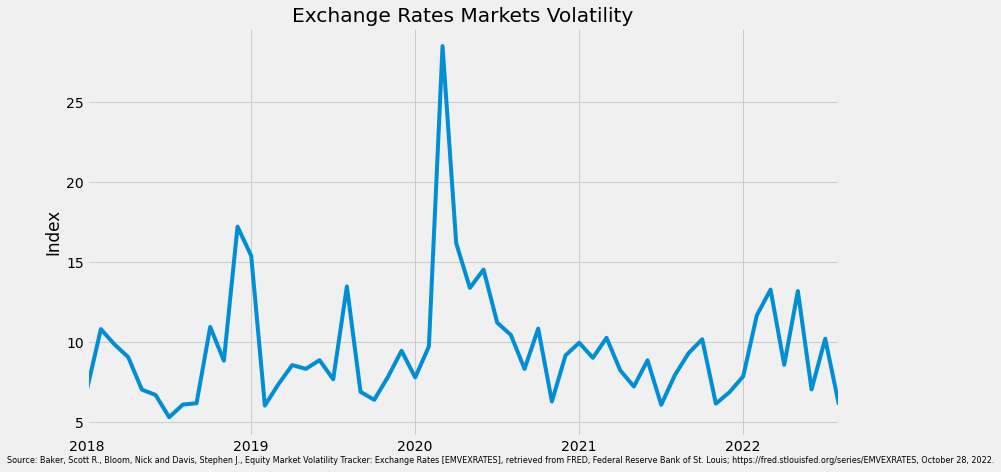

In [92]:
annotation = "Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Equity Market Volatility Tracker: Exchange Rates [EMVEXRATES], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/EMVEXRATES, October 28, 2022."
plt_ex_rate = ex_rate_df.plot(
    figsize=(12, 7), 
    title="Exchange Rates Markets Volatility",
    ylabel="Index"
)
plt_ex_rate.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")

### Twitter Economic Uncertainty Indices

In [93]:
teu_df = pd.read_excel(Path("../data/Twitter_Economic_Uncertainty.xlsx"),sheet_name="Sheet1", index_col="date")
display(teu_df.head())
display(teu_df.tail())

,TEU-ENG,TEU-USA,TEU-WGT,TEU-SCA,TMU-ENG,TMU-USA,TMU-WGT,TMU-SCA
date,,,,,,,,
2011-06-01,34.977314,39.442967,30.348728,104.105534,41.814588,65.620824,57.704897,166.454924
2011-06-02,73.563817,91.005509,78.242405,201.509622,67.602878,63.121922,52.420494,132.309089
2011-06-03,43.898007,71.343746,58.318990,164.992417,47.130142,65.956686,56.699973,145.117299
2011-06-04,70.436015,129.990484,105.572418,321.743322,39.638914,27.340489,27.090964,65.024720
2011-06-05,114.788234,214.368848,176.405940,436.805026,32.931358,69.683066,61.266693,134.689575


,TEU-ENG,TEU-USA,TEU-WGT,TEU-SCA,TMU-ENG,TMU-USA,TMU-WGT,TMU-SCA
date,,,,,,,,
2022-10-24,341.058869,245.751376,230.152949,91.767354,313.644746,168.585206,170.866628,59.821855
2022-10-25,269.802482,203.800805,179.815161,79.138203,195.861804,152.088894,168.544052,56.482692
2022-10-26,262.329853,218.251084,209.699863,78.827980,216.539830,128.717771,129.301788,44.680006
2022-10-27,265.695197,243.573568,244.737242,101.859799,199.735777,143.917983,142.561844,56.972998
2022-10-28,207.239430,176.808413,158.208954,70.531875,169.487240,137.648736,138.033859,52.240463


In [94]:
# Choose English -language tweets
teu_eng = teu_df.loc[pd.to_datetime("2018-01-01"):, "TEU-SCA"]
teu_eng

date
2018-01-01     14.958242
2018-01-02     56.565298
2018-01-03     56.390498
2018-01-04     49.827318
2018-01-05     26.785765
                 ...    
2022-10-24     91.767354
2022-10-25     79.138203
2022-10-26     78.827980
2022-10-27    101.859799
2022-10-28     70.531875
Name: TEU-SCA, Length: 1762, dtype: float64

Text(-80, -20, 'Source: Renault, Thomas, Baker, Scott R., Bloom, Nick and Davis, Stephen J., Twitter-based Uncertainty Indices, retrieved from Economic Policy Uncertainty; http://www.policyuncertainty.com/twitter_uncert.html, October 28, 2022.')

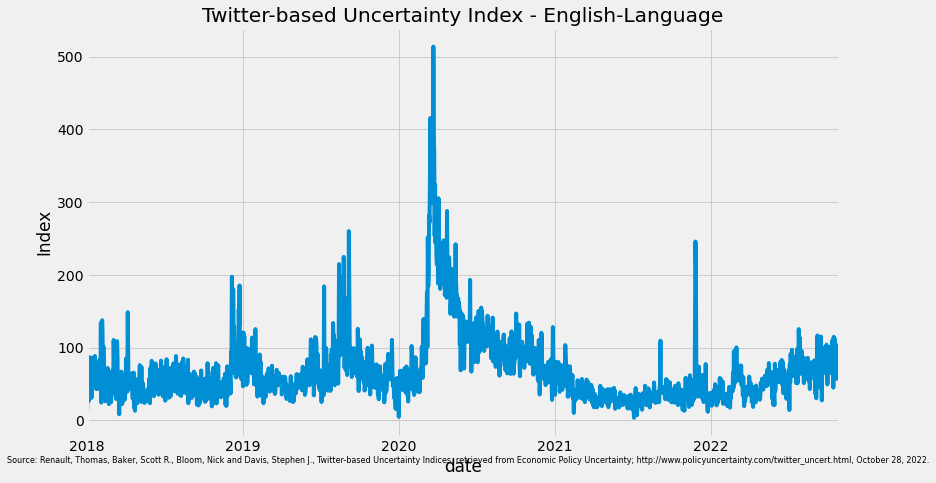

In [95]:
annotation = "Source: Renault, Thomas, Baker, Scott R., Bloom, Nick and Davis, Stephen J., Twitter-based Uncertainty Indices, retrieved from Economic Policy Uncertainty; http://www.policyuncertainty.com/twitter_uncert.html, October 28, 2022."
plt_teu = teu_eng.plot(
    figsize=(12, 7), 
    title="Twitter-based Uncertainty Index - English-Language",
    ylabel="Index"
)
plt_teu.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")

### All infectious disease equity markets volatility index

In [96]:
all_diseases_df = pd.read_csv(
    Path("../data/All_Infectious_EMV_Data.csv"), 
    parse_dates={"date" : ["year", "month", "day"]},
    index_col="date"
)
display(all_diseases_df.head())
display(all_diseases_df.tail())

,daily_infect_emv_index
date,
1985-01-01,0.0
1985-01-02,0.0
1985-01-03,0.0
1985-01-04,0.0
1985-01-05,0.0


,daily_infect_emv_index
date,
2022-10-24,8.56
2022-10-25,14.16
2022-10-26,14.04
2022-10-27,10.99
2022-10-28,8.24


We are only interested in disease data from 2018 to today

In [97]:
dis_df = all_diseases_df.loc[start_date:]
dis_df

,daily_infect_emv_index
date,
2018-01-01,0.00
2018-01-02,0.00
2018-01-03,0.73
2018-01-04,0.00
2018-01-05,1.22
...,...
2022-10-24,8.56
2022-10-25,14.16
2022-10-26,14.04


Text(-80, -20, 'Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Kost, Kyle, Sammon, Marco, Viratyosin, Tasaneeya, Daily Infectious Disease Equity Market Volatility Tracker, retrieved from Economic Policy Uncertainty; http://www.policyuncertainty.com/twitter_uncert.html, October 28, 2022.')

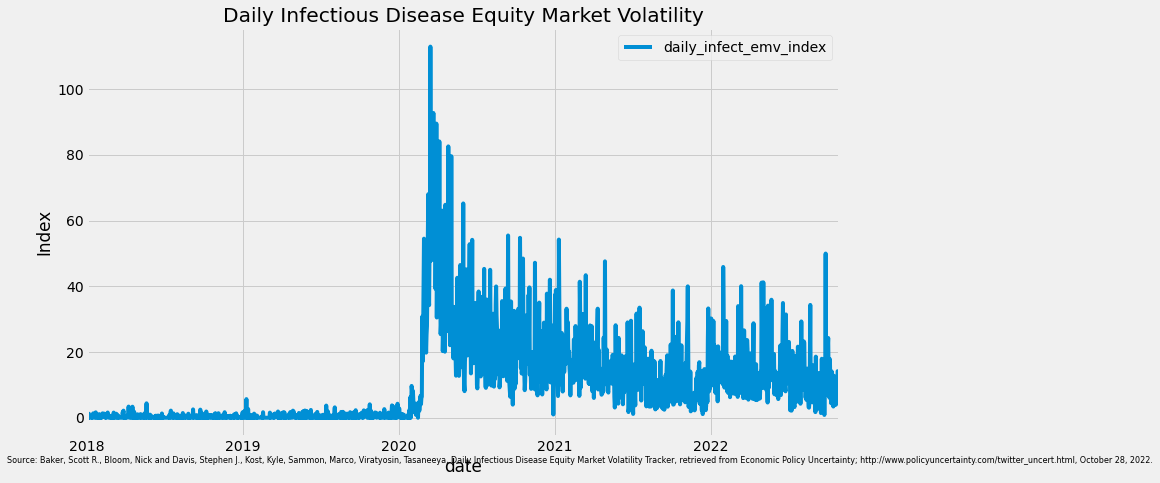

In [98]:
annotation = "Source: Baker, Scott R., Bloom, Nick and Davis, Stephen J., Kost, Kyle, Sammon, Marco, Viratyosin, Tasaneeya, Daily Infectious Disease Equity Market Volatility Tracker, retrieved from Economic Policy Uncertainty; http://www.policyuncertainty.com/twitter_uncert.html, October 28, 2022."
plt_dis = dis_df.plot(
    figsize=(12, 7), 
    title="Daily Infectious Disease Equity Market Volatility",
    ylabel="Index"
)
plt_dis.annotate(annotation, (0,0), (-80,-20), fontsize=8, xycoords="axes fraction", textcoords="offset points", va="top")